In [19]:
%load_ext autoreload 
import glob
import nibabel
import numpy as np
import re
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.core.debugger import set_trace
import os
import cc3d
import shutil
from collections import defaultdict
import pickle

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from utils import show_slices, check_patch, load, create_dicts, trim, video_comparison

from celluloid import Camera
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important}</style>"))
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`fcd_data/normalized_segmentation` -   
`fcd_data/normalized_data` -   
`fcd_data/normalized_label` - 
`fcd_data/fmriprep` - from Ironman server, 

In [7]:
labels_components = np.load('labels_info.npy', allow_pickle=True).item()
single_component_keys = {k for k,v in labels_components.items() if len(v['cc3d'][0]) == 2}

USE_GEOM_FEATURES = False
GEOM_FEATURES = ['thickness', 'sulc', 'curv']

root_label = '../fcd_data/normalized_label'
root_data = '../fcd_data/normalized_data/'
root_geom_features = '../fcd_data/preprocessed_data_anadezhda/'

paths_dict = create_dicts(root_label,
                         root_data,
                         root_geom_features, 
                         single_component_keys,
                         USE_GEOM_FEATURES, 
                         GEOM_FEATURES)

In [8]:
# # label_tensors = []

# centers = {}
# cc3d_dict = {}
# d_s = {}

# label_info = defaultdict(dict)

# for label, pdict in tqdm(paths_dict.items()):
    
#     mask_tensor = nibabel.load(pdict['mask']).get_fdata() > 0
#     mask_tensor = mask_tensor.astype(int)
# #     brain_tensor = nibabel.load(pdict['brain']).get_fdata()
# #     brain_tensor = brain_tensor*mask_tensor.astype(int)

#     label_tensor = nibabel.load(pdict['label']).get_fdata() * mask_tensor
#     label_tensor = np.array(label_tensor) > 0
    
#     labels_out = cc3d.connected_components(label_tensor, connectivity=26)
#     u, c = np.unique(labels_out, return_counts=True)
    
#     label_info[label]['cc3d'] = [u,c]
    
    
#     if len(u) > 2:
#         continue
        
#     mask = labels_out == 1
    
    
#     X,Y,Z = label_tensor.shape
    
#     xyz_grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)
#     xyz_grid = xyz_grid[mask]
#     center = xyz_grid.mean(0).astype(int)
    
#     dx = (np.sum(mask, axis=(1,2)) > 0).sum()
#     dy = (np.sum(mask, axis=(0,2)) > 0).sum()
#     dz = (np.sum(mask, axis=(0,1)) > 0).sum()
    
#     label_info[label]['d_s'] = [dx,dy,dz]
    
#     label_info[label]['center'] = center
    
    

In [9]:
# label_info['1']

In [10]:
# np.save('labels_info',label_info)

In [11]:
# prod_d = [np.prod(d) for d in d_s.values()]
# max_d = [max(d) for d in d_s.values()]

 - Take a look at the FCD volume size distribution
 - Take all crops fully covering FCD
 - Classify from other crops, compare statistics and all

# Symmetric crops

In [42]:
patches = []
PATCH_SIZE = 50
pad = PATCH_SIZE//2

In [43]:
def trim(brain_tensor, mask_tensor, label_tensor):
    '''
    mask_tensor - [H,W,D]
    brain_tensor - [N_features, H,W,D]
    label_tensor - [H,W,D]
    
    '''
    X,Y,Z = mask_tensor.shape
    
    X_mask = mask_tensor.sum(dim=[1,2]) > 0
    Y_mask = mask_tensor.sum(dim=[0,2]) > 0
    Z_mask = mask_tensor.sum(dim=[0,1]) > 0
    
    brain_tensor_trim = brain_tensor[:,X_mask][:,:,Y_mask][:,:,:,Z_mask]
    mask_tensor_trim = mask_tensor[X_mask][:,Y_mask][:,:,Z_mask]    
    label_tensor_trim = label_tensor[X_mask][:,Y_mask][:,:,Z_mask]
    
    return brain_tensor_trim, mask_tensor_trim, label_tensor_trim

In [44]:
for k,path_dict in paths_dict.items():

    path_dict = paths_dict[k]

    brain_tensor, mask_tensor, label_tensor = load(path_dict) # float, bool, int
#     brain_tensor_trim, mask_tensor_trim, label_tensor_trim = trim(brain_tensor, mask_tensor, label_tensor)
    
    X,Y,Z = brain_tensor.shape
    center = labels_components[k]['center']
    
    x,y,z = center
    patch_fcd = brain_tensor[x-pad:x+pad, y-pad:y+pad, z-pad:z+pad]
    fcd_label = label_tensor[x-pad:x+pad, y-pad:y+pad, z-pad:z+pad]
    
    diff = x-X//2
    x_ = X//2 - diff
    
    patch_nonfcd = brain_tensor[x_-pad:x_+pad, y-pad:y+pad, z-pad:z+pad]
    nonfcd_label = label_tensor[x_-pad:x_+pad, y-pad:y+pad, z-pad:z+pad]
    
    
    patches.append([patch_fcd, patch_nonfcd, fcd_label, nonfcd_label])
    
    break
    

In [ ]:
def 

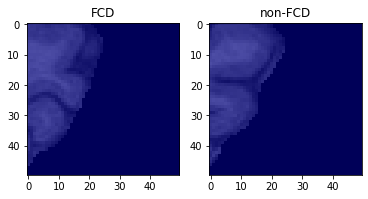

In [47]:
plt.ioff()

fig, ax = plt.subplots(1,2)
X_max, Y_max, Z_max = patch_fcd.shape
camera = Camera(fig)
n_slides= Y_max - 1

for i in range(n_slides):

    y_slice_pos = (Y_max//n_slides)*i

    patch_fcd_slice = patch_fcd[:,y_slice_pos,:]
    ax[0].imshow(patch_fcd_slice, 'gray')
    fcd_label_slice = fcd_label[:,y_slice_pos,:]
    ax[0].imshow(fcd_label_slice, 'jet', interpolation='none', alpha=0.7)
    
    patch_nonfcd_slice = patch_nonfcd[:,y_slice_pos,:][::-1,:]
    ax[1].imshow(patch_nonfcd_slice, 'gray')
    nonfcd_label_slice = nonfcd_label[:,y_slice_pos,:][::-1,:]
    ax[1].imshow(nonfcd_label_slice, 'jet', interpolation='none', alpha=0.7)

    ax[0].set_title('FCD')
    ax[1].set_title('non-FCD')

    camera.snap()

animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation